In [1]:
import pandas as pd
import numpy as np
import json
from bs4 import BeautifulSoup
import requests
import matplotlib.pyplot as plt

In [42]:
dicX = json.loads(BeautifulSoup(requests.get('http://coincap.io/front').content, "html.parser").prettify())
df_marketcap = pd.DataFrame(dicX)
P = df_marketcap[df_marketcap.mktcap > 5e9]
portfolio_coins = P['short']
#print("Portfolio coins with MCAP > 11 Billion:\n", portfolio_coins)

In [37]:
combined_df = pd.DataFrame()
for coin in portfolio_coins:
    dic_t = json.loads(BeautifulSoup(requests.get('http://coincap.io/history/180day/'+coin).content, "html.parser").prettify())
    prices = dic_t.get('price')
    coindf = pd.DataFrame.from_records(prices,columns=['time','price'])
    coindf['coin'] = coin
    combined_df = combined_df.append(coindf, ignore_index=True)
combined_df['time'] = pd.to_datetime(combined_df['time'],unit='ms')
combined_df['time'] = [d.date() for d in combined_df['time']]
operational_df = combined_df.groupby(['time', 'coin'],as_index=False)[['price']].mean()
operational_df = operational_df.set_index('time')
portfolio_new = operational_df.pivot(columns='coin')
daily_simple_returns = portfolio_new.pct_change()
returns_annual = daily_simple_returns.mean()*90
# get daily and covariance of returns of the stock
cov_daily = daily_simple_returns.cov()
cov_annual = cov_daily*90

In [38]:
# empty lists to store returns, volatility and weights of imiginary portfolios
port_returns = []
port_volatility = []
sharpe_ratio = []
stock_weights = []

# set the number of combinations for imaginary portfolios
num_assets = len(portfolio_coins)
num_portfolios = 50000

# populate the empty lists with each portfolios returns,risk and weights
for single_portfolio in range(num_portfolios):
    weights = np.random.random(num_assets)
    weights /= np.sum(weights)
    
    #print(weights)
    returns = np.dot(weights, returns_annual)*100
    
    #print(weights)
    volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))*100
    
    sharpe = returns / volatility
    sharpe_ratio.append(sharpe)
    port_returns.append(returns)
    port_volatility.append(volatility)
    stock_weights.append(weights)

# a dictionary for Returns and Risk values of each portfolio
portfolio = {'Returns': port_returns,
             'Volatility': port_volatility,
             'Sharpe Ratio': sharpe_ratio}

# extend original dictionary to accomodate each ticker and weight in the portfolio
for counter,symbol in enumerate(portfolio_coins):
    portfolio[symbol+' Weight'] = [Weight[counter] for Weight in stock_weights]

# make a nice dataframe of the extended dictionary
df = pd.DataFrame(portfolio)

In [39]:
column_order = ['Returns', 'Volatility', 'Sharpe Ratio'] + [coin+' Weight' for coin in portfolio_coins]
df = df[column_order]

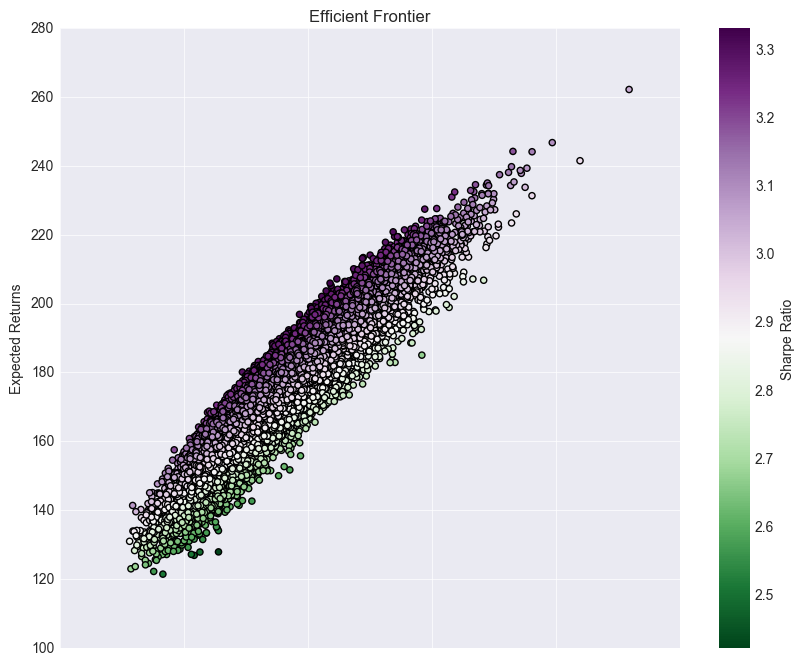

In [40]:
min_volatility = df['Volatility'].min()
max_sharpe = df['Sharpe Ratio'].max()
max_returns = df['Returns'].max()

# use the min, max values to locate and create the two special portfolios
sharpe_portfolio = df.loc[df['Sharpe Ratio'] == max_sharpe]
min_variance_port = df.loc[df['Volatility'] == min_volatility]
max_returns_port = df.loc[df['Returns'] == max_returns]

# plot frontier, max sharpe & min Volatility values with a scatterplot
plt.style.use('seaborn-dark')
df.plot.scatter(x='Volatility', y='Returns', c='Sharpe Ratio', cmap='PRGn_r', edgecolors='black', figsize=(10, 8), grid=True)

#plt.scatter(x=sharpe_portfolio['Volatility'], y=sharpe_portfolio['Returns'], c='red', marker='v', s=50)
#plt.scatter(x=min_variance_port['Volatility'], y=min_variance_port['Returns'], c='blue', marker='v', s=50 )

plt.xlabel('Volatility (Std. Deviation)')
plt.ylabel('Expected Returns')
plt.title('Efficient Frontier')
plt.show()

In [41]:
print('***********')
print(sharpe_portfolio.T)

***********
                   40659
Returns       205.925096
Volatility     61.798792
Sharpe Ratio    3.332186
BTC Weight      0.126233
ETH Weight      0.124265
XRP Weight      0.108879
BCH Weight      0.014188
ADA Weight      0.021042
LTC Weight      0.031589
XEM Weight      0.082122
NEO Weight      0.015416
EOS Weight      0.138400
XLM Weight      0.126562
IOT Weight      0.005001
DASH Weight     0.013935
XMR Weight      0.141826
TRX Weight      0.050544
